# Sample Series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as ss
from vtools.functions.filter import butterworth,cosine_lanczos

In [2]:
# Frequency, amplitude, phase of semidiurnal tide
# elev_tide = {
# "O1": (6.759775e-05 ,0.755 ,96.),\
# "K1": (7.292117e-05,1.2,105.),\
# "Q1": (6.495457e-05,1.15212,282.20352),\
# "P1": (7.251056e-05, 0.99465 ,40.40973),\
# "M2": (1.405189e-04,1.89,336.),\
# "S2": (1.454441e-04,0.449,336.)}

In [3]:
def interval(ts):
    """Sampling interval of series"""
    return ts.index.frequency

In [4]:
def bessel_df():
    """ Sample series with bessel function signals"""
    numpoints = 100000
    date_rng1 = pd.date_range(
        start='1992-03-07', periods=numpoints, freq='15min')
    date_rng2 = pd.date_range(
        start='1992-03-07', periods=numpoints, freq='15min')

    x = np.linspace(-5, 85, numpoints)
    df0 = pd.DataFrame(index=date_rng1, columns=['date'])
    df0['data'] = ss.jn(2, x)

    df1 = pd.DataFrame(index=date_rng2, columns=['one', 'two'])
    df1['one'] = ss.jn(2, x)
    df1['two'] = ss.jn(3, x)

    df2 = pd.DataFrame(index=date_rng2, columns=['data'])
    df2["data"] = ss.jn(4, x)
    return (df0, df1, df2)

In [5]:
def jay_flinchem_chirptest(c1=3.5, c2=5.5, c3=0.0002, c4=6.75):
    """ Approximation of the signal from Jay and Flinchem 1999
    A comparison of methods for analysis of tidal records containing multi-scale non-tidal background energy
    that has a small tide with noisy, river-influenced amplitude and subtide"""
    c1 = 3.5
    c2 = 5.5
    c3 = 0.0002
    c4 *= 2.*np.pi
    nval = 51*24
    omega = np.array([1., 2., 3., 4])
    gamma = np.array([40., 40., 30., 90.])*2.*np.pi/360.

    t = np.linspace(-42, 8., nval)
    tnorm = t*2.*np.pi
    ai, aip, bi, bip = ss.airy(-c3*np.square(tnorm-c4))
    Qr = c1 + c2*ai

    A = np.array([0.5, 1., 0.25, 0.1])
    Aj0 = A*1.
    Aj1 = np.array([0.4, 0.4, 0.4, 0.4])*.97

    D = np.zeros_like(t)

    for i in range(4):
        j = i+1
        phij = gamma[i]*np.sqrt(Qr-1)
        #print("phi {}".format(phij))
        Aj = Aj0[i]*(1.-Aj1[i]*np.sqrt(Qr))
        D += Aj*np.cos(tnorm*omega[i]-phij)

    dr = pd.date_range('2000-01-01', periods=nval, freq='H')
    return pd.DataFrame({"data": (D+Qr), "D": D, "Qr": Qr}, index=dr)

In [6]:
def small_subtide(subtide_scale=0., add_nan=False):
    """Inspired by large tidal flow with small Qr undercurrent with 72hr period
    This is a tough lowpass filtering job because the diurnal band is large and 
    must be supressed in order to see the more subtle subtidal amplitude"""
    freqmult = np.pi/180./3600.   # converts cycles/hour to rad/sec
    discharge_tide = {
        "O1": (13.943035*freqmult, 0.5*0.755, 96),
        "K1": (15.041069*freqmult, 0.5*1.2, 105.),
        "M2": (28.984104*freqmult, 0.75*1.89, 336.),
        "S2": (30.*freqmult, 0.75*0.449, 336.)}

    month_nsec = 30*86400
    t = np.arange(0, month_nsec, 900)
    nsample = len(t)
    nanstart = nsample//3
    numnan = nsample//10
    FLOW_SCALE = 100000.
    tide = t*0.
    for key, (freq, amp, phase) in discharge_tide.items():
        print(key, freq, amp, phase)
        tide += FLOW_SCALE*amp*np.cos(freq*t-phase*np.pi/180.)

    subtide_freq = 2.*np.pi/(3.*86400.)  # one cycle per 3 days
    # Add a subtide that is very small compared to the tidal amplitude
    tide += subtide_scale*FLOW_SCALE*np.cos(subtide_freq*t)

    tide[nanstart:(nanstart+numnan)] = np.nan
    dr = pd.date_range(start="2000-01-01", periods=nsample, freq="15min")
    return pd.DataFrame({"values": tide}, dr)

In [7]:
def extra():
    fig, ax0 = plt.subplots(1)
    ts.plot(ax=ax0)
    plt.show()

    jf = jay_flinchem_chirptest()
    fig, ax0 = plt.subplots(1)
    jf.data.plot(ax=ax0)
    plt.show()

    (df0, df1, df2) = create_sample_df()
    fig, ax0 = plt.subplots(1)
    df1.plot(ax=ax0)
    df2.plot(ax=ax0)

O1 6.7597741241891e-05 0.3775 96
K1 7.292116029712528e-05 0.6 105.0
M2 0.00014051890153901625 1.4175 336.0
S2 0.0001454441043328608 0.33675 336.0


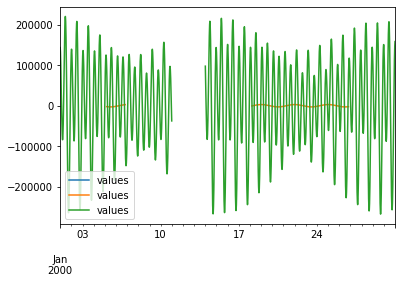

<class 'pandas.tseries.offsets.Minute'>


In [8]:
ts = small_subtide(subtide_scale=0.03, add_nan=True)
cutoff = pd.tseries.frequencies.Hour(40)
filtered0 = butterworth(ts, cutoff, order=8)
filtered1 = cosine_lanczos(ts, cutoff)
fig, ax0 = plt.subplots(1)
filtered0.plot(ax=ax0)
filtered1.plot(ax=ax0)
ts.plot(ax=ax0)
plt.show()

print(type(ts.index.freq))